In [22]:
"""
NOTE: This file checks the feasability of the disturbance based method and also generates the data for the learning based method.
"""

'\nNOTE: This file checks the feasability of the disturbance based method and also generates the data for the learning based method.\n'

In [23]:
import torch
import os
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.widgets import Button   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(main_dir)
print(main_dir)
path_dynamics_model_weights = os.path.join(main_dir, "old_files", "dynamics_model_weights_encoder")
import old_files.dynamics_learning_encoder.mlmodel_encoder as mlmodel
dynamics_model = mlmodel.load_model("run_4_encoder_increased_wind30.pth", path_dynamics_model_weights)
dynamics_model.mu.to(device)
dynamics_model.f.to(device)
dynamics_model.g.to(device)

/home/rohang/learning_based_adaptive_reachability


g(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [24]:
class SimDataFeasability:
    def __init__(self, data_path):
        with open(data_path, 'rb') as f:
            self.trajectory_data = pickle.load(f)
        self.dt = 0.01
        self.a_g = 9.81
        ## right now the entire data is (2100000, 3). Need to distribute it into different trajectories
        self.trajetory_length_individual = 1000
        self.trajectory_data_individual = {}
        self.split_trajectories()
        for traj_id in self.trajectory_data_individual.keys():
            self.add_NN_acceleration(traj_id)

    def split_trajectories(self):
        num_trajectories = self.trajectory_data['velocities'].shape[0] // self.trajetory_length_individual
        for i in range(num_trajectories):
            self.trajectory_data_individual[i] = {}
            start_idx = i * self.trajetory_length_individual
            end_idx = (i + 1) * self.trajetory_length_individual
            for key, value in self.trajectory_data.items():
                if key == 'metadata':
                    continue
                self.trajectory_data_individual[i][key] = value[start_idx:end_idx]
    def add_NN_acceleration(self, traj_id):
        traj_data = self.trajectory_data_individual[traj_id]
        a_x_NN, a_y_NN = self.NN_dynamics_inference_zero_wind(
            traj_data['velocities'][:, 0], traj_data['velocities'][:, 1],
            traj_data['controls'][:, 0], traj_data['controls'][:, 1]
        )
        self.trajectory_data_individual[traj_id]['a_x_NN'] = a_x_NN
        self.trajectory_data_individual[traj_id]['a_y_NN'] = a_y_NN
        self.trajectory_data_individual[traj_id]['a_x_NN_err'] = traj_data['accelerations'][:, 0] - a_x_NN
        self.trajectory_data_individual[traj_id]['a_y_NN_err'] = traj_data['accelerations'][:, 1] - a_y_NN
        self.trajectory_data_individual[traj_id]['avg_a_NN_x_err'] = np.mean(self.trajectory_data_individual[traj_id]['a_x_NN_err'])
        self.trajectory_data_individual[traj_id]['avg_a_NN_y_err'] = np.mean(self.trajectory_data_individual[traj_id]['a_y_NN_err'])

    def NN_dynamics_inference_zero_wind(self, v_x, v_y, roll, pitch):
        v_x = torch.tensor(v_x, dtype=torch.float32).to(device)           # []
        v_y = -torch.tensor(v_y, dtype=torch.float32).to(device)
        velocity = torch.stack((v_x, v_y), dim=1)  # [N, 2]
        roll = torch.tensor(-roll, dtype=torch.float32).to(device)
        pitch = torch.tensor(-pitch, dtype=torch.float32).to(device)
        control = torch.stack((pitch, roll), dim=1)  # [N, 2]
         # NN prediction with zero wind
        with torch.no_grad():
            wind_zero = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)  # [1, 2]
            wind_encoding_zero = dynamics_model.mu(wind_zero)  # [1, latent_dim]
            wind_encoding_zero = wind_encoding_zero.repeat(velocity.shape[0], 1)
            output_NN = dynamics_model.f(torch.cat([velocity, wind_encoding_zero], dim=1)) + \
                        torch.matmul(dynamics_model.g(velocity).reshape(-1, 2, 2), control.unsqueeze(-1)).squeeze(-1)  # [N, 2]
            a_x_NN = output_NN[:, 0].cpu().numpy()
            a_y_NN = -output_NN[:, 1].cpu().numpy()
        return a_x_NN, a_y_NN

In [25]:
file_name = "quadrotor_dynamics_varied_wind_rw_control_ic500_ws42"
data_path = os.path.join("..", "..", file_name) + ".pkl"
adapt_data = SimDataFeasability(data_path)

Text(0, 0.5, 'mean of acc - NN[zero winds] in X-direction (m/s^2)')

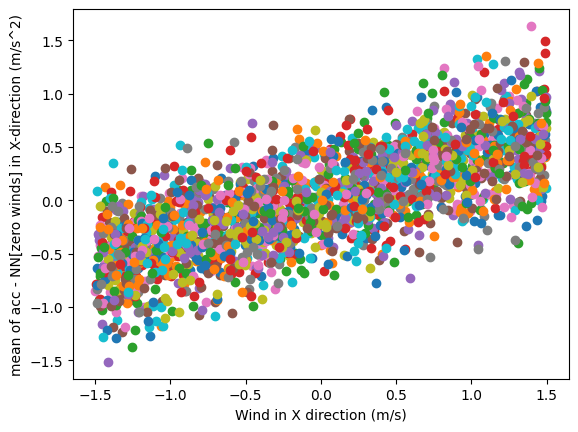

In [26]:
for trajectory_id, trajectory in adapt_data.trajectory_data_individual.items():
    if (trajectory_id % 10) == 0:
        plt.scatter(trajectory['winds'][100,0], (trajectory['avg_a_NN_x_err']))
plt.xlabel('Wind in X direction (m/s)')
plt.ylabel('mean of acc - NN[zero winds] in X-direction (m/s^2)')

Text(0, 0.5, 'mean of acc - NN[zero winds] in Y-direction (m/s^2)')

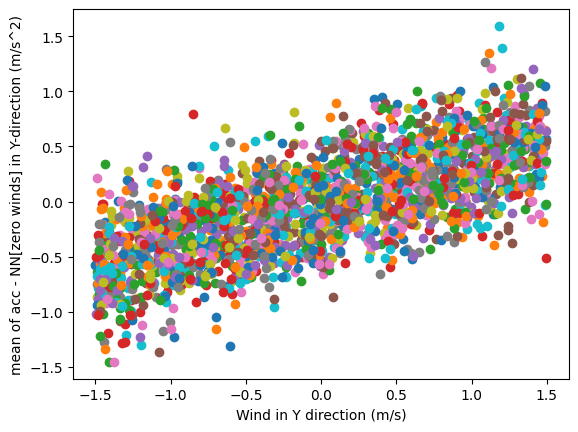

In [27]:
for trajectory_id, trajectory in adapt_data.trajectory_data_individual.items():
    if (trajectory_id % 10) == 0:
        plt.scatter(trajectory['winds'][100,1], (trajectory['avg_a_NN_y_err']))
plt.xlabel('Wind in Y direction (m/s)')
plt.ylabel('mean of acc - NN[zero winds] in Y-direction (m/s^2)')

In [28]:
## Dumping the data for learning based method
data_path_dir = "../disturbance_based_data"
data_dump_path = "disturbance_residual_" + file_name + ".pkl"
with open(os.path.join(data_path_dir, data_dump_path), 'wb') as f:
    pickle.dump(adapt_data.trajectory_data_individual, f)

[ 0.26097932  0.40410952 -0.01043386]


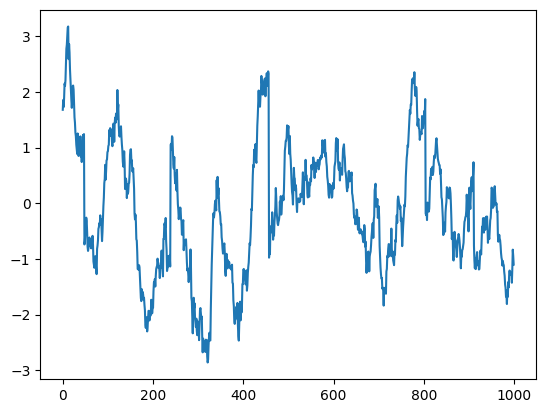

In [29]:
plt.plot(adapt_data.trajectory_data_individual[0]['a_x_NN_err'])
print(adapt_data.trajectory_data_individual[0]['winds'][0])

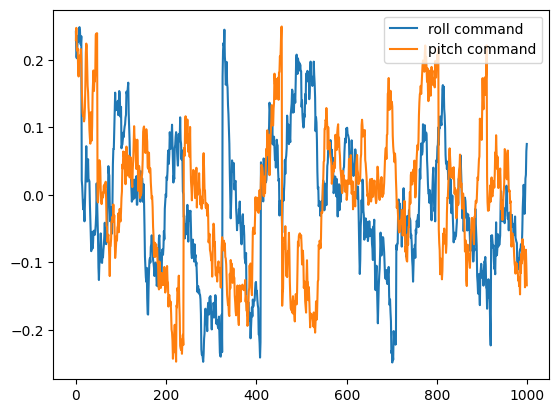

In [30]:
plt.plot(adapt_data.trajectory_data_individual[0]['controls'][:,0], label='roll command')
plt.plot(adapt_data.trajectory_data_individual[0]['controls'][:,1], label='pitch command')
plt.legend()